In [ ]:
# We need to run this because there might be too many packages with the name "midi" and the wrong one is getting priority:

!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.2
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.1
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.7
dlib==19.18.0
dm-tree==0.1.5
doc

In [ ]:
# If there is an extra, uninstall it using this:

#!pip uninstall midi

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time 

#!pip install wavio
#import wavio

!apt-get install swig -y
#!cd /content/drive/MyDrive/python-midi-master/python-midi-master/ && python "setup.py" install
!pip install git+https://github.com/vishnubob/python-midi@feature/python3

from IPython import display

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
  Cloning https://github.com/vishnubob/python-midi (to revision feature/python3) to /tmp/pip-req-build-fpg6df4w
  Running command git clone -q https://github.com/vishnubob/python-midi /tmp/pip-req-build-fpg6df4w
  Running command git checkout -b feature/python3 --track origin/feature/python3
  Switched to a new branch 'feature/python3'
  Branch 'feature/python3' set up to track remote branch 'feature/python3' from 'origin'.
  Created wheel for midi: filename=midi-0.2.3-cp37-cp37m-linux_x86_64.whl size=281257 sha256=70d6648ba32b7a9c21c4734a71e4640ec9aeb62fe34dd0efd75f8d910c66a6d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-j1evmpjv/wheels/63/f9/4a/5e881f1126db389dfda75672c69b5be5bf51b0925cc7b5cbcf
Successfully built midi


In [ ]:
# This code was taken and edited from Dan Schiebler's RBM code at http://danshiebler.com/2016-08-10-musical-tensorflow-part-one-the-rbm/
# and is based on Dan Johnson's midi manipulation code (see the above link). This comes from the midi_manipulation.py file
# in the above website link.
import midi

lowerBound = 36 #original:24
upperBound = 52 #original:102
span = upperBound-lowerBound


def midiToNoteStateMatrix(midifile, squash=True, span=span):
    pattern = midi.read_midifile(midifile)

    timeleft = [track[0].tick for track in pattern]

    posns = [0 for track in pattern]

    statematrix = []
    time = 0

    state = [[0,0] for x in range(span)]
    statematrix.append(state)
    condition = True
    while condition:
        if time % (pattern.resolution / 4) == (pattern.resolution / 8):
            # Crossed a note boundary. Create a new state, defaulting to holding notes
            oldstate = state
            state = [[oldstate[x][0],0] for x in range(span)]
            statematrix.append(state)
        for i in range(len(timeleft)): #For each track
            if not condition:
                break
            while timeleft[i] == 0:
                track = pattern[i]
                pos = posns[i]

                evt = track[pos]
                if isinstance(evt, midi.NoteEvent):
                    if (evt.pitch < lowerBound) or (evt.pitch >= upperBound):
                        pass
                        # print "Note {} at time {} out of bounds (ignoring)".format(evt.pitch, time)
                    else:
                        if isinstance(evt, midi.NoteOffEvent) or evt.velocity == 0:
                            state[evt.pitch-lowerBound] = [0, 0]
                        else:
                            state[evt.pitch-lowerBound] = [1, 1]
                elif isinstance(evt, midi.TimeSignatureEvent):
                    if evt.numerator not in (2, 4):
                        # We don't want to worry about non-4 time signatures. Bail early!
                        # print "Found time signature event {}. Bailing!".format(evt)
                        out =  statematrix
                        condition = False
                        break
                try:
                    timeleft[i] = track[pos + 1].tick
                    posns[i] += 1
                except IndexError:
                    timeleft[i] = None

            if timeleft[i] is not None:
                timeleft[i] -= 1

        if all(t is None for t in timeleft):
            break

        time += 1

    S = np.array(statematrix)
    statematrix = np.hstack((S[:, :, 0], S[:, :, 1]))
    statematrix = np.asarray(statematrix).tolist()
    return statematrix

def noteStateMatrixToMidi(statematrix, name="example", span=span):
    # Channel 9 is drums:
    c = 9

    statematrix = np.array(statematrix)
    if not len(statematrix.shape) == 3:
        statematrix = np.dstack((statematrix[:, :span], statematrix[:, span:]))
    statematrix = np.asarray(statematrix)
    pattern = midi.Pattern()
    track = midi.Track()
    pattern.append(track)
    
    span = upperBound-lowerBound
    tickscale = 55
    
    lastcmdtime = 0
    prevstate = [[0,0] for x in range(span)]
    for time, state in enumerate(statematrix + [prevstate[:]]):  
        offNotes = []
        onNotes = []
        for i in range(span):
            n = state[i]
            p = prevstate[i]
            if p[0] == 1:
                if n[0] == 0:
                    offNotes.append(i)
                elif n[1] == 1:
                    offNotes.append(i)
                    onNotes.append(i)
            elif n[0] == 1:
                onNotes.append(i)
        for note in offNotes:
            # getting rid of the clap, replace with stick click:
            #if note == 3:
                #note = 1
            track.append(midi.NoteOffEvent(channel = c, tick=(time-lastcmdtime)*tickscale, pitch=note+lowerBound))
            lastcmdtime = time
        for note in onNotes:
            # getting rid of the clap, replace with stick click:
            #if note == 3:
                #note = 1
            track.append(midi.NoteOnEvent(channel = c, tick=(time-lastcmdtime)*tickscale, velocity=40, pitch=note+lowerBound))
            lastcmdtime = time
            
        prevstate = state
    
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)

    midi.write_midifile("/content/drive/MyDrive/Music GAN Images/{}.mid".format(name), pattern)

In [ ]:
info_df = pd.read_csv("drive/MyDrive/e-gmd-v1.0.0-midi/e-gmd-v1.0.0/e-gmd-v1.0.0.csv")
info_df.head()

,drummer,session,id,style,bpm,beat_type,time_signature,duration,split,midi_filename,audio_filename,kit_name
0,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Acoustic Kit
1,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,JingleStacks (2nd Hi-Hat)
2,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Studio (Live Room)
3,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Classic Rock
4,drummer1,drummer1/eval_session,drummer1/eval_session/1,funk/groove1,138,beat,4-4,27.8261,test,drummer1/eval_session/1_funk-groove1_138_beat_...,drummer1/eval_session/1_funk-groove1_138_beat_...,Jazz Funk


In [ ]:
len(info_df)

45537

In [ ]:
info_df["beat_type"].value_counts()

fill    26961
beat    18576
Name: beat_type, dtype: int64

In [ ]:
# Picking out our genres for training data:

# Shows first 30 genres (in order of most common):
#print(list(info_df["style"].value_counts().index)[:30])

# was originally this:
#genres = list(info_df["style"].value_counts().index)[:7]
# now this:
genres = ['rock', 'hiphop', 'funk', 'punk', 'rock/halftime', 'funk/purdieshuffle', 'country', 'funk/rock', 'funk/fast']

In [ ]:
# Check how many training points we will have:
count = 0
for i in info_df.index:
  if (type(info_df.loc[i,"midi_filename"]) != float) and (info_df.loc[i,"beat_type"] == 'beat') and (info_df.loc[i,"style"] in genres):
    count += 1

count

10105

In [ ]:
# This code loads/generates the songlist from the info dataframe:

# Loading previously saved songlist:
import pickle

with open("/content/drive/MyDrive/Music GAN Images/songlist.txt", "rb") as fp:
 songlist = pickle.load(fp)


# Making/saving new songlist:
#songlist = []

#for i in info_df.index:
    #if (type(info_df.loc[i,"midi_filename"]) != float) and (info_df.loc[i,"beat_type"] == 'beat') and (info_df.loc[i,"style"] in genres):    # some are nan
        #path = "drive/MyDrive/e-gmd-v1.0.0-midi/e-gmd-v1.0.0/" + info_df.loc[i,"midi_filename"]

        #song =  np.array(midiToNoteStateMatrix(path))
        #if np.array(song).shape[0] > 15:
            #songlist.append(song)

# Saving songlist for future use:
#import pickle

#with open("/content/drive/MyDrive/Music GAN Images/songlist.txt", "wb") as fp:
  #pickle.dump(songlist, fp)

print(len(songlist), "songs processed.")

9632 songs processed.


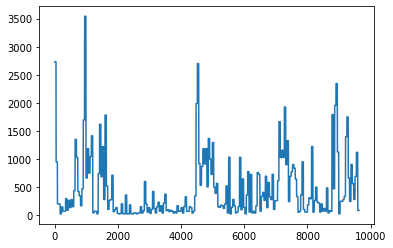

224.5
451.2544642857143
3543


In [ ]:
# songlist[i].shape[1] is always 2*(# of notes), 32 in this case.

# songlist[i].shape[0] is roughly the length of the song.
L = [songlist[i].shape[0] for i in range(len(songlist))]
plt.plot(L)
plt.show()

print(np.median(L))
print(np.mean(L))
print(np.max(L))

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64

maxlen = 184
train_songs_padded = tf.keras.preprocessing.sequence.pad_sequences(songlist, maxlen=maxlen, padding='post').astype('float32')

train_songs_padded = tf.expand_dims(train_songs_padded, axis = -1)

train_songs_padded.shape

TensorShape([9632, 184, 32, 1])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_songs_padded).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [ ]:
# Creating a custom activation, a rescaling/shift of tanh so the range is (0,1).
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation

def positive_tanh(x):
  return 0.5*(tf.nn.tanh(x) + 1)

get_custom_objects().update({'positive_tanh': Activation(positive_tanh)})

In [ ]:
# Generator model:
# (Do we want to use something other than Conv2DTranspose to boost up from 1 dimension?)

def make_generator_model(r, t, val):
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(23*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((23, 4, 256)))
    assert model.output_shape == (None, 23, 4, 256) # Note: None is the batch size

    if t:
      model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2]))) # was 5,5
    else:
      model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    assert model.output_shape == (None, 23, 4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    if t:
      model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    assert model.output_shape == (None, 46, 8, 64) #1
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    if t:
      model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    assert model.output_shape == (None, 92, 16, 32) #1
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # activation was here, and was tanh. We changed to positive_tanh.
    if t:
      model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(Activation(positive_tanh, name='positive_tanh'))
    assert model.output_shape == (None, 184, 32, 1)


    return model

In [ ]:
# This is the final activator, turning the array of floats into 0s and 1s, so that 
# it can actually be read/written as a MIDI file. We have a choice of 4 different rectifiers,
# each deciding whether m[i,j] = 0 or 1 based on the matrix's average, nth percentile,
# an average of a travelling window, or a fixed value.

def avg_rectifier(T):
  m = np.array(T)

  avg = np.mean(m)

  new_m = np.zeros(np.shape(m))

  for i in range(m.shape[0]):
    for j in range(m.shape[1]):
      if m[i,j] > avg:
        new_m[i,j] = 1
      else:
        new_m[i,j] = 0

  new_m = tf.expand_dims(new_m, axis = -1)
  new_m = tf.expand_dims(new_m, axis = 0)

  return new_m


def percentile_rectifier(T, perc):
  m = np.array(T)

  # This gets the perc^th percentile:
  percentile = np.percentile(m,perc)

  new_m = np.zeros(np.shape(m))

  for i in range(m.shape[0]):
    for j in range(m.shape[1]):
      if m[i,j] > percentile:
        new_m[i,j] = 1
      else:
        new_m[i,j] = 0

  new_m = tf.expand_dims(new_m, axis = -1)
  new_m = tf.expand_dims(new_m, axis = 0)

  return new_m


def window_rectifier(T, pad):
  m = np.array(T)

  new_m = np.zeros(np.shape(m))

  for i in range(pad,m.shape[0]-pad):
    for j in range(pad,m.shape[1]-pad):
      # Here we take the average of a (2*pad+1)x(2*pad+1) window around m[i,j]
      L = m[i-pad:i+pad+1,j-pad:j+pad+1]
      L[pad,pad] = 0
      window_avg = np.sum(L)/((2*pad+1)^2 - 1)

      if m[i,j] > window_avg:
        new_m[i,j] = 1
      else:
        new_m[i,j] = 0
  
  # Here we're losing the information on the edges:
  new_m[:pad,:pad] = 0
  new_m[m.shape[0]-pad:,m.shape[1]-pad:] = 0

  new_m = tf.expand_dims(new_m, axis = -1)
  new_m = tf.expand_dims(new_m, axis = 0)

  return new_m


def absolute_rectifier(T, value):
  m = np.array(T)

  new_m = np.zeros(np.shape(m))
  # value is what decides whether m[i,j] = 0 or 1

  for i in range(m.shape[0]):
    for j in range(m.shape[1]):
      if m[i,j] > value:
        new_m[i,j] = 1
      else:
        new_m[i,j] = 0

  new_m = tf.expand_dims(new_m, axis = -1)
  new_m = tf.expand_dims(new_m, axis = 0)

  return new_m

# Now try to make this into a tf-friendly activation function:

# WE CAN'T DO THIS. These rectifiers are basically the Heaviside step function shifted
# horizontally, and the step function has derivative 0 almost everywhere so weights will never update!

In [ ]:
# This is a generic discriminator, reducing dimension equally with each layer.

def make_discriminator_model1(r, t, val, dropout):
    model = tf.keras.Sequential()
    if t:
      model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[184, 32, 1], kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=[184, 32, 1], kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [92, 16, 1]

    if t:
      model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [46, 8, 1]

    if t:
      model.add(layers.Conv2D(128, (1, 1), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(128, (1, 1), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [23, 4, 1]

    if t:
      model.add(layers.Conv2D(256, (1, 1), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(256, (1, 1), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size is still [23, 2, 1]

    if t:
      model.add(layers.Conv2D(512, (1, 1), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(512, (1, 1), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size is still [23, 1, 1]

    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

In [ ]:
# This discriminator will focus on the placements of notes in the note hierarchy, and not the placement of notes in time

def make_discriminator_model2(r, t, val, dropout):
    model = tf.keras.Sequential()
    if t:
      model.add(layers.Conv2D(32, (3, 3), strides=(2, 1), padding='same', input_shape=[184, 32, 1], kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(32, (3, 3), strides=(2, 1), padding='same', input_shape=[184, 32, 1], kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [92, 32, 1]
    
    if t:
      model.add(layers.Conv2D(64, (3, 3), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(64, (3, 3), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [46, 32, 1]
    
    if t:
      model.add(layers.Conv2D(128, (3, 3), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(128, (3, 3), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [23, 32, 1]

    if t:
      model.add(layers.Conv2D(256, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(256, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [23, 32, 1]

    # now a projection down to the 32-length vector of notes
    #model.add(layers.Dense(32))
    # or this?:
    #if t:
      #model.add(layers.Conv2D(512, (1, 1), strides=(23, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    #else:
      #model.add(layers.Conv2D(512, (1, 1), strides=(23, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(dropout))
    # size now is [1, 32, 1]

    if t:
      model.add(layers.Conv2D(512, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(512, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [11, 32, 1]

    if t:
      model.add(layers.Conv2D(1024, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(1024, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [5, 32, 1]

    if t:
      model.add(layers.Conv2D(2048, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(2048, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [2, 32, 1]

    # This used to be (1,1) strides:
    if t:
      model.add(layers.Conv2D(4096, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(4096, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [1, 32, 1]

    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

In [ ]:
# This discriminator will focus on time-based information, projecting onto the time axis rather than notes.

def make_discriminator_model3(r, t, val, dropout):
    model = tf.keras.Sequential()
    if t:
      model.add(layers.Conv2D(32, (3, 3), strides=(1, 2), padding='same', input_shape=[184, 32, 1], kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(32, (3, 3), strides=(1, 2), padding='same', input_shape=[184, 32, 1], kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [184, 16, 1]
    
    if t:
      model.add(layers.Conv2D(64, (3, 3), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(64, (3, 3), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [184, 8, 1]
    
    if t:
      model.add(layers.Conv2D(128, (3, 3), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(128, (3, 3), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [184, 4, 1]

    if t:
      model.add(layers.Conv2D(256, (1, 1), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(256, (1, 1), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [184, 2, 1]

    if t:
      model.add(layers.Conv2D(512, (1, 1), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    else:
      model.add(layers.Conv2D(512, (1, 1), strides=(1, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    # size now is [184, 1, 1]

    # This is a new addition:
    #if t:
      #model.add(layers.Conv2D(1024, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    #else:
      #model.add(layers.Conv2D(1024, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(dropout))
    # size now is [92, 1, 1]

    #if t:
      #model.add(layers.Conv2D(2048, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    #else:
      #model.add(layers.Conv2D(2048, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(dropout))
    # size now is [46, 1, 1]

    #-------New(er)-------:
    #if t:
      #model.add(layers.Conv2D(4096, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=val, axis=[0, 1, 2])))
    #else:
      #model.add(layers.Conv2D(4096, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=r)))
    #model.add(layers.LeakyReLU())
    #model.add(layers.Dropout(dropout))
    # size now is [23, 1, 1]

    model.add(layers.Flatten())
    model.add(layers.Dense(1))


    return model

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
EPOCHS = 20
noise_dim = 100
# make this a square (1,4,16,... etc.) for the subplotting code:
num_examples_to_generate = 1

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function
def train_step(images, w1, w2, w3):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc1_tape, tf.GradientTape() as disc2_tape, tf.GradientTape() as disc3_tape:
        generated_images = generator(noise, training=True)

        real_output1 = discriminator1(images, training=True)
        fake_output1 = discriminator1(generated_images, training=True)
        real_output2 = discriminator2(images, training=True)
        fake_output2 = discriminator2(generated_images, training=True)
        real_output3 = discriminator3(images, training=True)
        fake_output3 = discriminator3(generated_images, training=True)

        # What loss should the generator get?
        # We'll try a weighted average...but is that the best for a possibly negative output?
        # w3 tends towards only having ride-timing.

        avg_fake_output = (w1*fake_output1 + w2*fake_output2 + w3*fake_output3)/(w1 + w2 + w3)

        gen_loss = generator_loss(avg_fake_output)
        disc1_loss = discriminator_loss(real_output1, fake_output1)
        disc2_loss = discriminator_loss(real_output2, fake_output2)
        disc3_loss = discriminator_loss(real_output3, fake_output3)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator1 = disc1_tape.gradient(disc1_loss, discriminator1.trainable_variables)
    gradients_of_discriminator2 = disc2_tape.gradient(disc2_loss, discriminator2.trainable_variables)
    gradients_of_discriminator3 = disc3_tape.gradient(disc3_loss, discriminator3.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer1.apply_gradients(zip(gradients_of_discriminator1, discriminator1.trainable_variables))
    discriminator_optimizer2.apply_gradients(zip(gradients_of_discriminator2, discriminator2.trainable_variables))
    discriminator_optimizer3.apply_gradients(zip(gradients_of_discriminator3, discriminator3.trainable_variables))

In [ ]:
def train(dataset, epochs, val, tag, w1, w2, w3):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, w1, w2, w3)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save(generator, epoch + 1, seed, tag, val)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save(generator, epochs, seed, tag, val)

In [ ]:
def generate_and_save(model, epoch, test_input, tag, val):
    # Notice 'training' is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(int(np.sqrt(num_examples_to_generate)), int(np.sqrt(num_examples_to_generate))))

    for i in range(predictions.shape[0]):
        plt.subplot(int(np.sqrt(num_examples_to_generate)), int(np.sqrt(num_examples_to_generate)), i+1)
        if tag == "absolute":
          plt.imshow(absolute_rectifier(predictions[i,:,:,0], val)[0,:,:,0], cmap='gray')
          plt.axis('off')
          noteStateMatrixToMidi(absolute_rectifier(predictions[i,:,:,0], val)[0,:,:,0], "song " + str(i) + " of epoch " + str(epoch))
        elif tag == "percentile":
          plt.imshow(percentile_rectifier(predictions[i,:,:,0], val)[0,:,:,0], cmap='gray')
          plt.axis('off')
          noteStateMatrixToMidi(percentile_rectifier(predictions[i,:,:,0], val)[0,:,:,0], "song " + str(i) + " of epoch " + str(epoch))
        elif tag == "window":
          plt.imshow(window_rectifier(predictions[i,:,:,0], val)[0,:,:,0], cmap='gray')
          plt.axis('off')
          noteStateMatrixToMidi(window_rectifier(predictions[i,:,:,0], val)[0,:,:,0], "song " + str(i) + " of epoch " + str(epoch))
        elif tag == "average":
          plt.imshow(avg_rectifier(predictions[i,:,:,0])[0,:,:,0], cmap='gray')
          plt.axis('off')
          noteStateMatrixToMidi(avg_rectifier(predictions[i,:,:,0])[0,:,:,0], "song " + str(i) + " of epoch " + str(epoch))

    plt.savefig('/content/drive/MyDrive/Music GAN Images/Images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

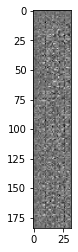

In [ ]:
# the 3 fields for the generator are: 
# (L2 regularization parameter for the kernel, T/F value of whether to use kernel constraint, MaxNorm value for the kernel
# constraint [if included using the T/F value]).

# Here we make the generator and apply it to sample noise:
generator = make_generator_model(0.0001, False, 0)
noise = tf.random.normal([1, 100])
S = generator(noise, training=False)

plt.imshow(S[0, :, :, 0], cmap='gray')

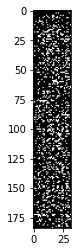

In [ ]:
# Now apply the rectifier to make all entries 0 or 1:
newS = percentile_rectifier(S[0,:,:,0], 80)
plt.imshow(newS[0,:,:,0], cmap='gray')

# Save the test song:
noteStateMatrixToMidi(np.array(newS[0,:,:,0]), "test song")

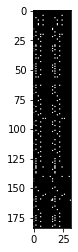

In [ ]:
# Just checking what a real song looks like:
plt.imshow(songlist[5][:184,:], cmap='gray')

In [ ]:
# the 4 fields for the discriminators are: 
# (L2 regularization parameter for the kernel, T/F value of whether to use a kernel constraint, MaxNorm value for the kernel
# constraint [if included using the T/F value], and dropout rate).

discriminator1 = make_discriminator_model1(0.0001, False, 0, 0.3)   # Dropout was 0.3 earlier
discriminator2 = make_discriminator_model2(0.0001, False, 0, 0.3)
discriminator3 = make_discriminator_model3(0.0001, False, 0, 0.3)
decision1 = discriminator1(newS)
decision2 = discriminator2(newS)
decision3 = discriminator3(newS)
print(np.array(decision1)[0][0], np.array(decision2)[0][0], np.array(decision3)[0][0])
print()
# positive for real, negative for fake.

# weighted sum of 3 decisions:
weight1 = 1
weight2 = 1.5
weight3 = 0.7
print((weight1*np.array(decision1)[0][0] + weight2*np.array(decision2)[0][0] + weight3*np.array(decision3)[0][0])/(weight1+weight2+weight3))

-0.009957407 0.0006157328 -0.004081995

-0.0037160012889216887


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer1 = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer2 = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer3 = tf.keras.optimizers.Adam(1e-4)

import os
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer1=discriminator_optimizer1,
                                 discriminator_optimizer2=discriminator_optimizer2,
                                 discriminator_optimizer3=discriminator_optimizer3,
                                 generator=generator,
                                 discriminator1=discriminator1,
                                 discriminator2=discriminator2,
                                 discriminator3=discriminator3)

In [ ]:
# Now for actual training:

# Last three numbers are weights for discriminator 1, 2, and 3. The generator's loss function is fed the weighted average of
# the decision from the 3 discriminators. Ex.: (w1, w2, w3) = (1, 0, 0) means the generator's loss function is only being
# fed the 1st discriminator's decision.
# The input before the weights is a tag which identifies which rectifier to use to make sure all entries are 0 or 1.
# Available rectifiers: absolute, percentile, window, and average.
# Before this is a value which, for the window/absolute/percentile rectifiers, specifies the window padding/
# fixed value/percentile which those rectifiers will use.

train(train_dataset, EPOCHS, 90, "percentile", 1, 1.15, 1.1)

# Best results I have found have been with percentile rectifier, 75-95th percentile and
# absolute rectifier with fixed value of around 0.15.

In [ ]:
# Things to possibly add: 
# 1. Mess with kernel sizes...Do they need to be square for the discriminators which work by projecting to 1 dimension
# at a time rather than projecting to dimension 0 all at the same time (i.e. discriminators 2 and 3)? Try non-square
# kernel sizes like 3x1 or 1x3. 6x1 makes sense since 184/32 = 5.75 ~ 6.

# 2. Seen from viewing the images produces, in later epochs (10-35 and on) the notes stack on the right side of the
# matrix (indices [:,16-32], the off notes), WHY is this? How do we prevent this? 

# 3. Play with kernel regularization to prevent overfitting, as well as perhaps instituting a maxnorm constraint for 
# weights (this will slow training so the best examples don't occur in epoch 2). Ex:
# model.add(layers.Conv2D(2048, (1, 1), strides=(2, 1), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001), kernel_constraint = tf.keras.constraints.MaxNorm(max_value=2, axis=[0, 1, 2])))

# 4. do we need discriminator 3?
# 5. play around with the rectifier..absolute, window, or average/percentile?
# 6. other ways of reducing dimension other than a Dense layer? (Conv2D used...Seems to work better.)
# 7. 0-30 epochs seems good so far, with best results in epochs 1-5.



In [ ]:
# Note value finding:

#note_test1 = np.zeros((184,32))
# shape = (184, 32)
#note = 18

#for i in range(note_test1.shape[0]):
  #for j in range(note_test1.shape[1]):
    #if i%4 == 0:
      #note_test1[i,0] = 1
    #if i%4 == 2:
      #note_test1[i,2] = 1
    #note_test1[i,6] = 1
    #note_test1[i,22] = 1

#noteStateMatrixToMidi(note_test1, "note test 1")

# 0 is bass drum
# 1 is stick click
# 2 is snare drum
# 3 is clap
# 4 is piccolo snare drum
# 5 is (tight) floor tom
# 6 is closed hihat
# 7 is medium tom
# 8 is hihat pedal close
# 9 is high tom
# 10 is open hihat
# 11 is (tight) high tom
# 12 is (tight) higher tom
# 13 is crash
# 14 is (tight) highest tom
# 15 is ride
# 16-32 are nothing

# 16-32 are the "off" notes, where as 0-15 are the "on" notes.
# Note that for the closed hihat instrument to function it needs "off" notes.